In [1]:
#The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(None, 'f250fdcd-cca8-4f77-9de6-d9c02c3919c3', 'p-20e03b82add8102e5369b2cb96ae8c8d36d0dc05')
pc = project.project_context

In [2]:
print('Project Name: {0}'.format(project.get_name()))
print('Project Description: {0}'.format(project.get_description()))
print('Project Bucket Name: {0}'.format(project.get_project_bucket_name()))
print('Project Assets (Connections): {0}'.format(project.get_assets(asset_type='connection')))

Project Name: Python Data Analysis
Project Description: Python Data Analysis
Project Bucket Name: pythondataanalysis-donotdelete-pr-xgmwfxjcvmypvc
Project Assets (Connections): []


In [3]:
# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
#from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Import datast 
# df = pd.read_csv(project.get_file('data.csv'), usecols=['horsepower', 'price'])
store = pd.read_csv(project.get_file('store.csv'))
train = pd.read_csv(project.get_file('train.csv'), index_col='Date', parse_dates=True)
test = pd.read_csv(project.get_file('test.csv'))
train.shape, test.shape, store.shape

((1017209, 8), (41088, 8), (1115, 10))

In [7]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [8]:
# Extract Year, Month, Day, Wee columns 
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekofYear'] = train.index.weekofyear

train['SalesPerCustomer'] = train['Sales']/train['Customers']

In [9]:
# Checking the data when the store is closed 
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f651d99ed30>]],
      dtype=object)

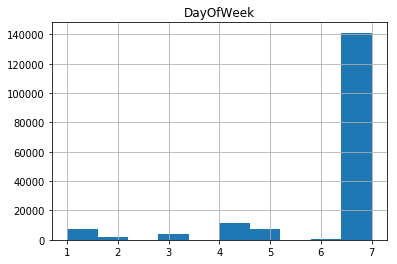

In [10]:
# Check when the store was closed 
train_store_closed.hist('DayOfWeek')

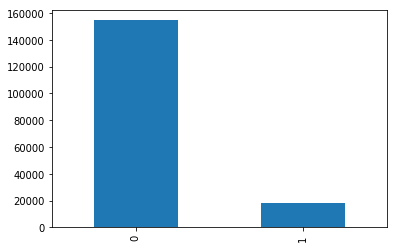

In [11]:
# Check whether there school was closed for holyday 
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar')

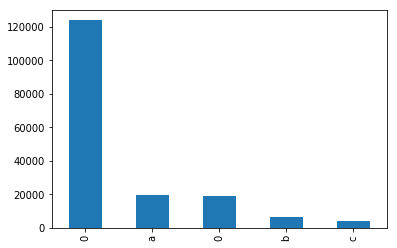

In [12]:
# Check whether there school was closed for holyday 
train_store_closed['StateHoliday'].value_counts().plot(kind='bar')

In [13]:
# Check the null values
# In here there is no null value 
train.isnull().sum()

Store                    0
DayOfWeek                0
Sales                    0
Customers                0
Open                     0
Promo                    0
StateHoliday             0
SchoolHoliday            0
Year                     0
Month                    0
Day                      0
WeekofYear               0
SalesPerCustomer    172869
dtype: int64

In [14]:
# Number of days with closed stores
train[(train.Open == 0)].shape[0]

172817

In [15]:
# Okay now check No. of dayes store open but sales zero ( It might be caused by external refurbishmnent)
train[(train.Open == 1) & (train.Sales == 0)].shape[0]

54

In [16]:
# Work with store data 
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [17]:
# Check null values 
# Most of the columns has null values 

store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [19]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [20]:
# Again check it and now its okay 

store.isnull().sum().sum()

0

In [21]:
# Work with test data 
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [22]:
# check null values ( Only one feature Open is empty)
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [23]:
# Assuming stores open in test
test.fillna(1, inplace=True)

In [24]:
# Again check 
test.isnull().sum().sum()

0

In [25]:
# Join train and store table 
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [26]:
train_store_joined.groupby('StoreType')['Customers', 'Sales', 'SalesPerCustomer'].sum().sort_values('Sales', ascending='desc')

,Customers,Sales,SalesPerCustomer
StoreType,,,
b,31465621,159231395,7.987612e+04
c,92129705,783221426,9.744876e+05
d,156904995,1765392943,2.918350e+06
a,363541434,3165334859,4.043129e+06


In [27]:
# Closed and zero-sales observations 
train_store_joined[(train_store_joined.Open == 0) | (train_store_joined.Sales==0)].shape

(172871, 22)

In [28]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]
train_store_joined_open

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
6,1,6,4364,500,1,0,0,0,2015,7,...,8.728000,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
7,1,5,3706,459,1,0,0,0,2015,7,...,8.074074,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
8,1,4,3769,503,1,0,0,0,2015,7,...,7.493042,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
9,1,3,3464,463,1,0,0,0,2015,7,...,7.481641,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
10,1,2,3558,469,1,0,0,0,2015,7,...,7.586354,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


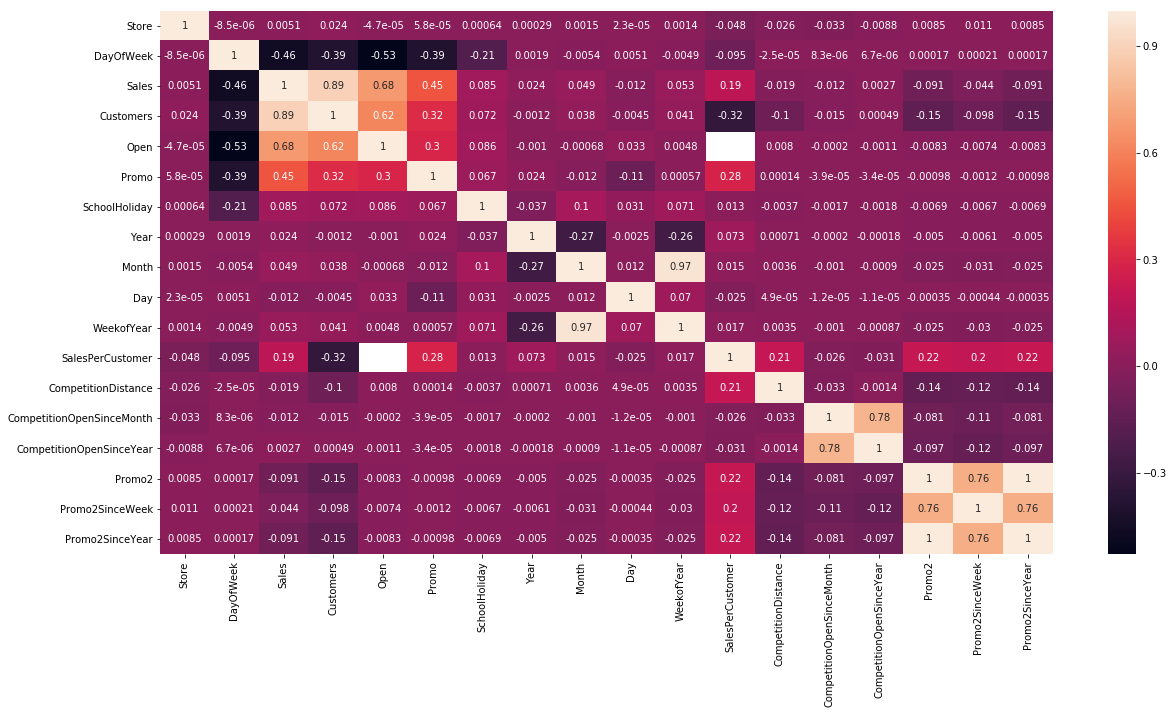

In [29]:
plt.figure(figsize=(20, 10))
sns.heatmap(train_store_joined.corr(), annot=True)

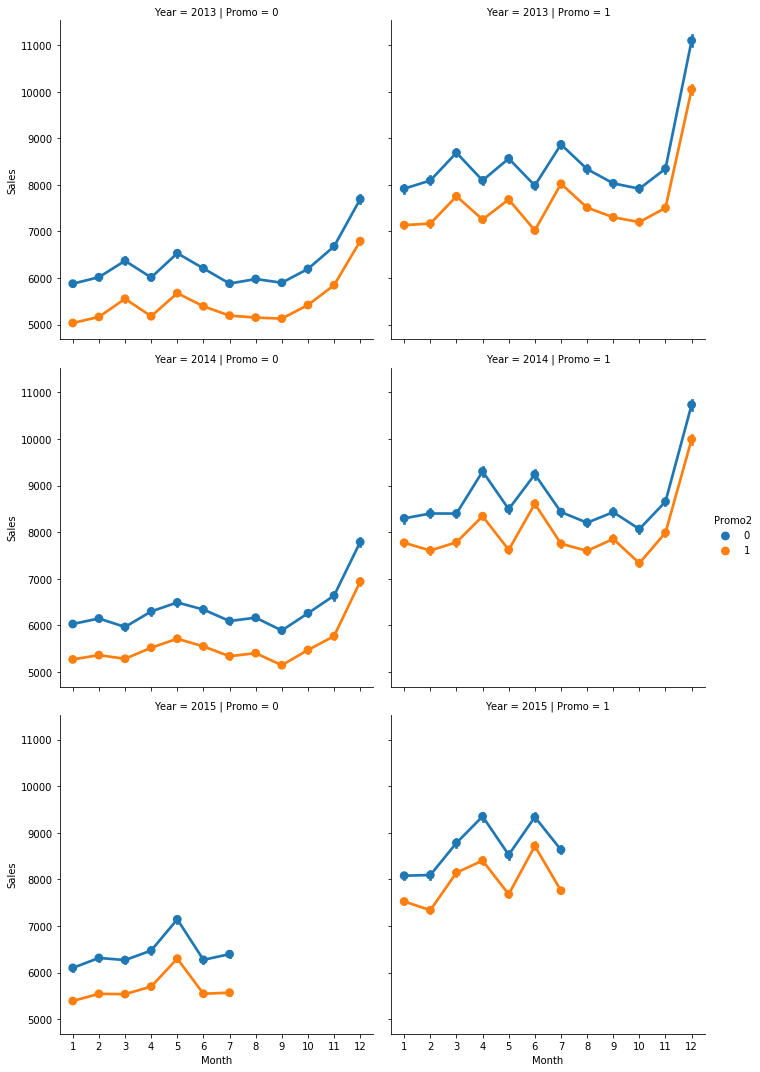

In [30]:
# Now plot the sales trend over the month 
sns.factorplot(data = train_store_joined_open, x='Month', y='Sales',
              col ='Promo', hue='Promo2', row='Year')

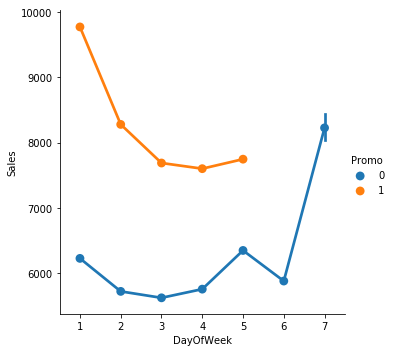

In [31]:
# Sales and trend over days
sns.factorplot(data= train_store_joined_open, x='DayOfWeek', y="Sales",
              hue='Promo')

In [32]:
pd.plotting.register_matplotlib_converters()

In [33]:
# Data Preparation: input should be float type 

# our Sales data is int type so lets make it float
train['Sales'] = train['Sales'] * 1.00

train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [34]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

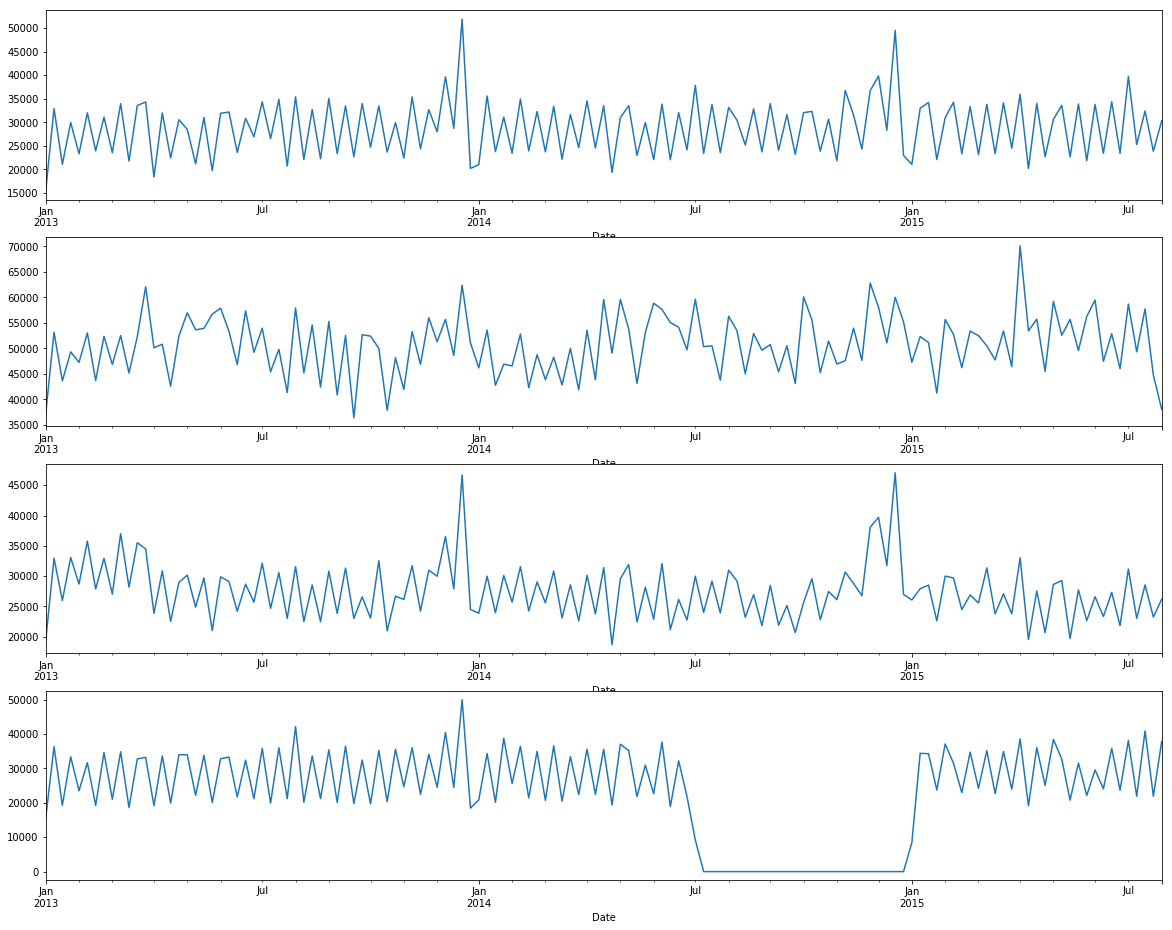

In [35]:
# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))

# Visualize Trend 
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


# will be used to resample the speed column of our DataFrame
#The 'W' indicates we want to resample by week. At the bottom of this post is a summary of different time frames.
# You could use for Day = d, MOnth = m, Year = y

In [36]:
# lets create a functions to test the stationarity 
def test_stationarity(timeseries):
    # Determine rolling statestics 
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    # plotting rolling statestics 
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
    plt.legend(loc='best')
    plt.show()
    
    # Performing Dickey-Fuller test 
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

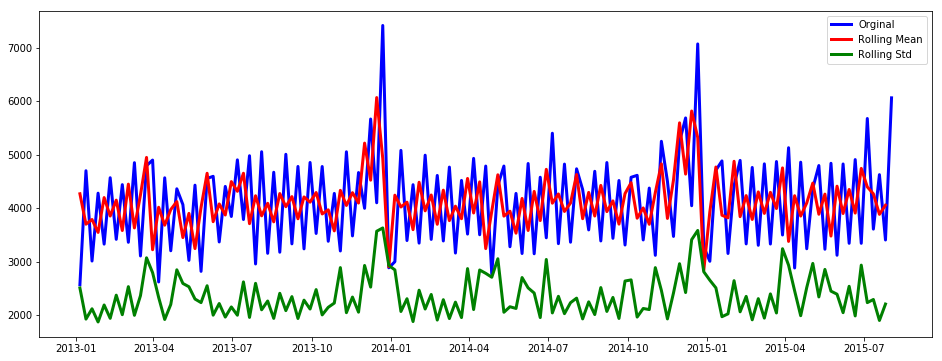

Result of Dickey-Fuller test:
ADF Statestics: -6.218237
P-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [37]:
test_stationarity(sales_a)

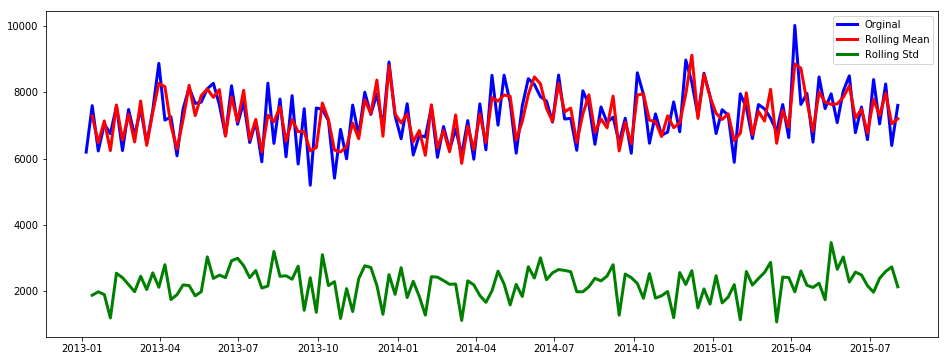

Result of Dickey-Fuller test:
ADF Statestics: -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [38]:
test_stationarity(sales_b)

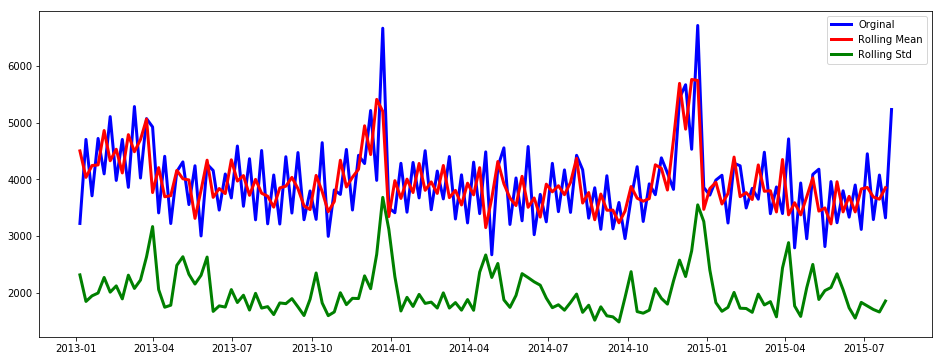

Result of Dickey-Fuller test:
ADF Statestics: -4.374784
P-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [39]:
test_stationarity(sales_c)

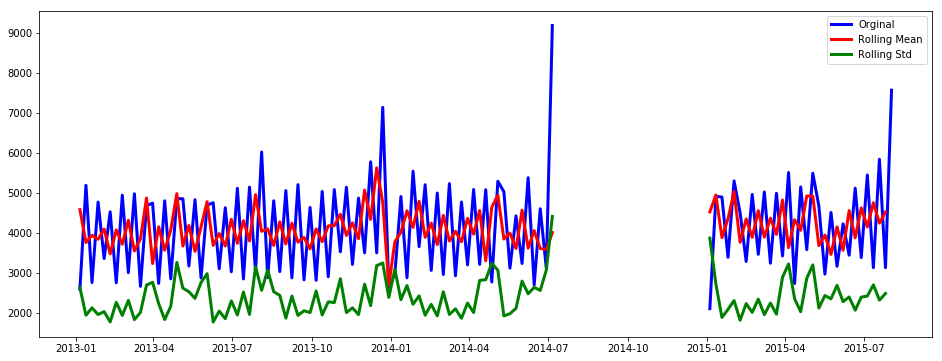

Result of Dickey-Fuller test:
ADF Statestics: -6.237461
P-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [40]:
test_stationarity(sales_d)

In [41]:
# plotting trends and seasonality 

def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False)
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');
    
    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    plt.title('Decomposition Plots')

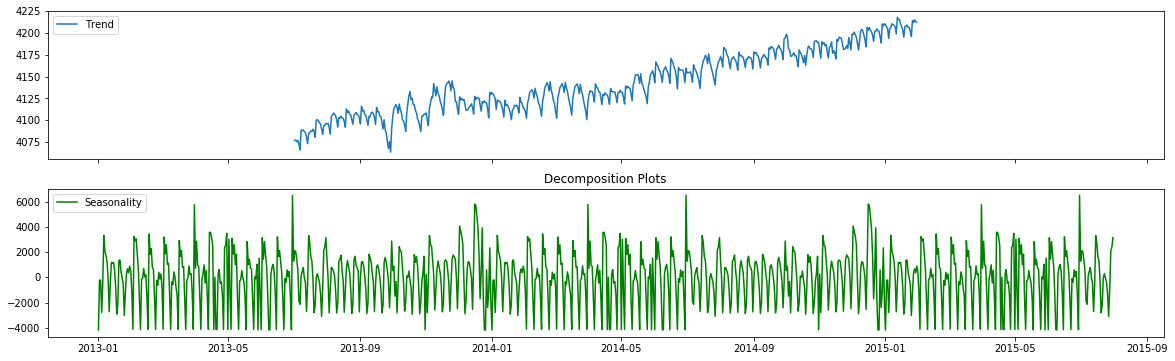

In [42]:
plot_timeseries(sales_a, 'a')

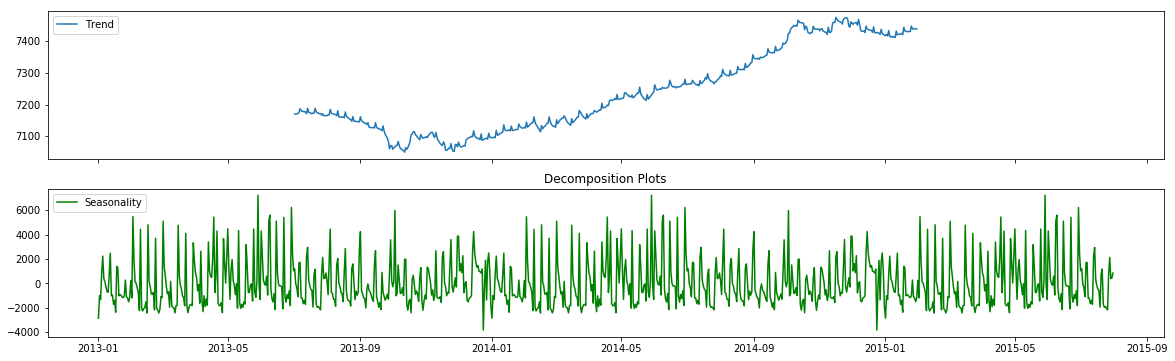

In [43]:
plot_timeseries(sales_b, 'b')

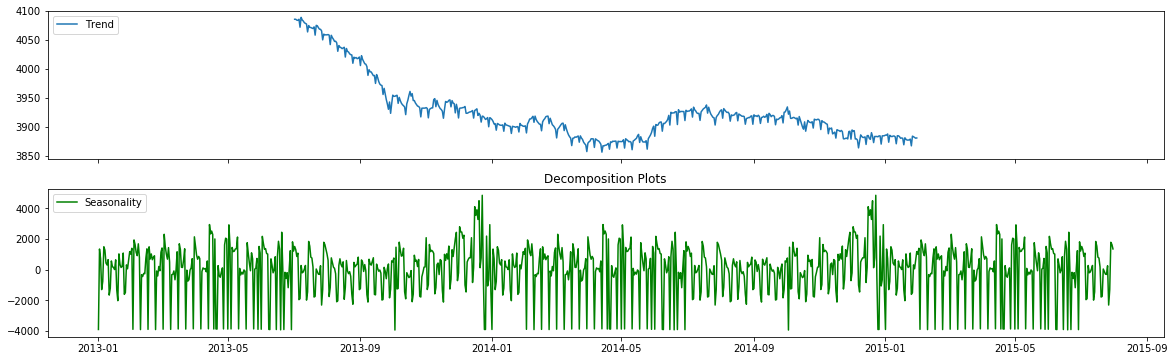

In [44]:
plot_timeseries(sales_c, 'c')

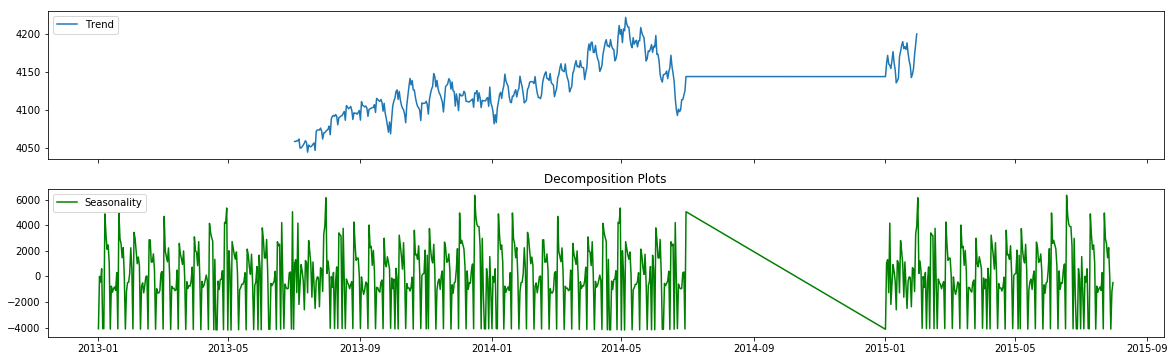

In [45]:
plot_timeseries(sales_d, 'd')

In [46]:
def auto_corr(sales):
    lag_acf = acf(sales, nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
    
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0, linestyle='--', color='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)), linestyle='--', color='red')
    plt.title('PACF')

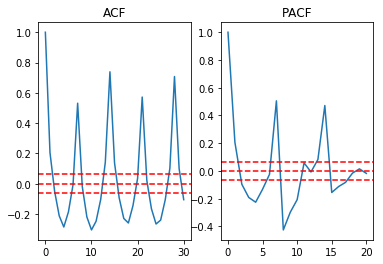

In [47]:
# ACF and PCF for store A
auto_corr(sales_a)

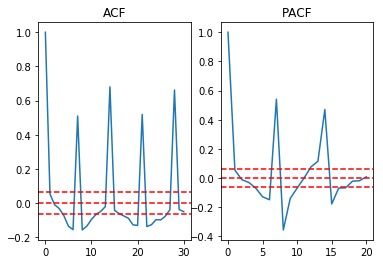

In [48]:
# ACF and PCF for store B
auto_corr(sales_b)

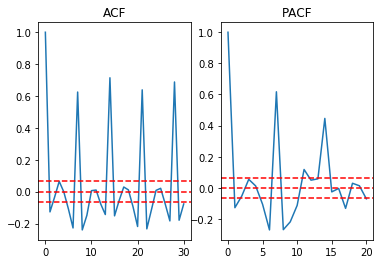

In [49]:
# ACF and PCF for store C
auto_corr(sales_c)

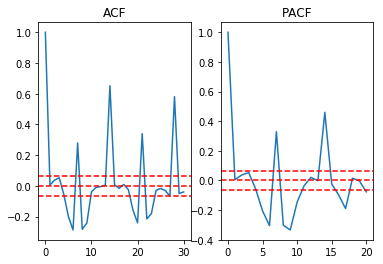

In [50]:
# ACF and PCF for store D
auto_corr(sales_d)

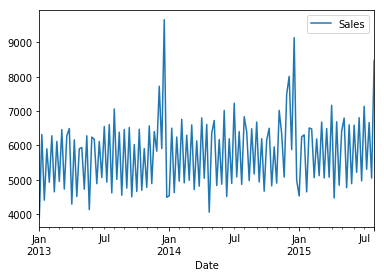

In [51]:
# Summering sales on per week basis 
# ARIMA = Autoregresive Integrated Moving Average 


train_arima = train.resample('w').mean()
train_arima = train_arima[['Sales']]
train_arima.plot()

In [52]:
train_arima.head()

,Sales
Date,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960


In [53]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [54]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.203980769132
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.822052279775
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.7057912673176
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107341433
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.33669434058
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.886830502456
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.017189113568
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259663458
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.0426171359954
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908841574688
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089752304
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842539744
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.5804531929352
A

In [55]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.098     -5.652      0.000      -0.747      -0.362
ma.L1         -1.1418      0.055    -20.766      0.000      -1.250      -1.034
ar.S.L12      -0.1554      0.110     -1.417      0.156      -0.370       0.060
ma.S.L12      -1.0093      0.700     -1.441      0.150      -2.382       0.364
sigma2      6.236e+05   4.65e+05      1.342      0.180   -2.87e+05    1.53e+06


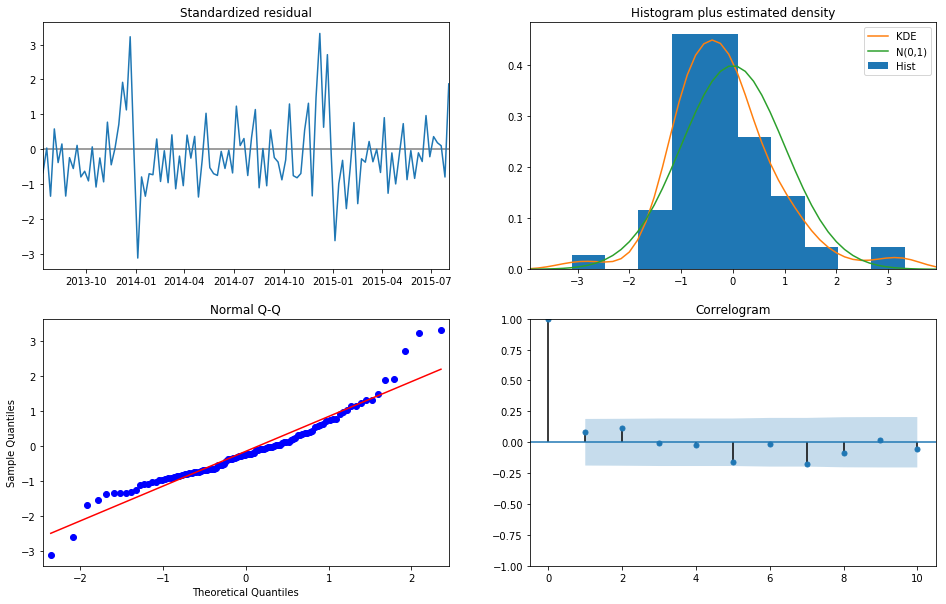

In [56]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

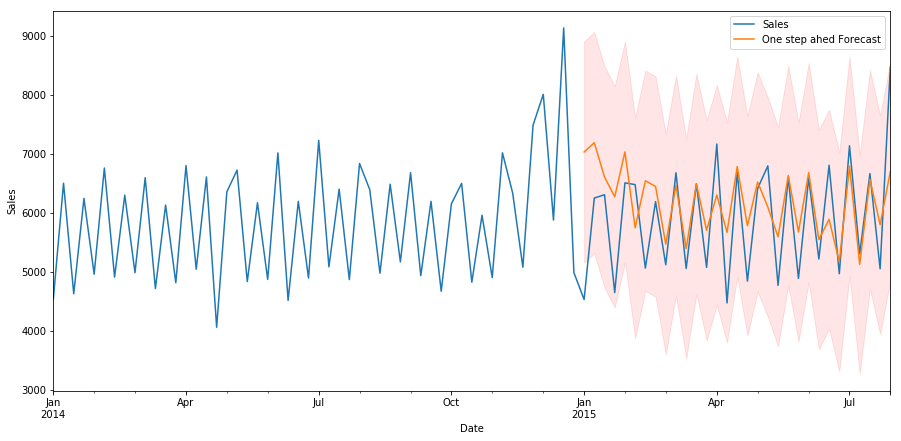

Root Mean Squared Error =  867.9549535500163


In [57]:
# Model prediction 

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast 
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [ ]:
# Save your predicted results for future validation. 
# You could find this results in output sections

train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')